In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/model.h5')
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [ ]:
import cv2
import os

prototxtPath = os.path.sep.join(["/content", "deploy.prototxt"])
weightsPath = os.path.join("/content",
	"res10_300x300_ssd_iter_140000.caffemodel")
net = cv2.dnn.readNet(prototxtPath, weightsPath)

In [ ]:
image = cv2.imread("/content/2020_4$largeimg_1457131882.jpg")
orig = image.copy()
(h, w) = image.shape[:2]

# construct a blob from the image
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
	(104.0, 177.0, 123.0))

# pass the blob through the network and obtain the face detections
print("computing face detections...")
net.setInput(blob)
detections = net.forward()

[INFO] computing face detections...


In [ ]:
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
for i in range(0, detections.shape[2]):
	confidence = detections[0, 0, i, 2]

	# .5 confidence filter
	if confidence > 0.5:
		# coordinates of the bounding box 
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")

		# check that bounding box fall within the dimensions of frame
		(startX, startY) = (max(0, startX), max(0, startY))
		(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

		# processing
		face = image[startY:endY, startX:endX]
		face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
		face = cv2.resize(face, (224, 224))
		face = img_to_array(face)
		face = preprocess_input(face)
		face = np.expand_dims(face, axis=0)

		# passing to mask detector
		(mask, withoutMask) = model.predict(face)[0]

		# bouding box stuff
		label = "Mask" if mask > withoutMask else "No Mask"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		# probability
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# display the label and bounding box
		cv2.putText(image, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

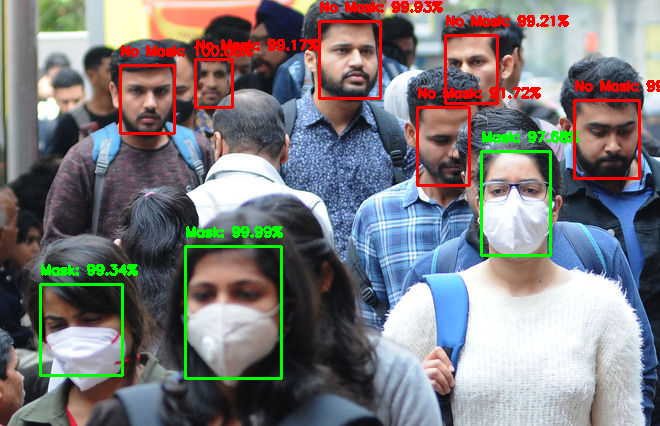

In [ ]:
# show the output image
from google.colab.patches import cv2_imshow
cv2_imshow(image)
# cv2.waitKey(0)